In [1]:
import pandas as pd
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
#from glob import glob
from sklearn.utils import shuffle
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall, AUC

In [2]:
#get the shape of one of the images
image_path = r"C:\Users\user\Anaconda\Programs\image_data\train\normal\KEMP_IMG_DATA_1.png"
img = Image.open(image_path)
img_width, img_height = img.size
img_channels = 3 if img.mode == 'RGB' else 1
print("Image Dimensions (Width, Height, Channels):", img_width, img_height, img_channels)

Image Dimensions (Width, Height, Channels): 480 720 1


Image Dataset Creation

In [3]:
class ImageClassification:
    def __init__(self,path1): #path1 represents the directory to the image dataset
        #creating dataframes (df) for the train and test sets
        self.train_df = self._create_df(path1, "train")
        self.test_df = self._create_df(path1, "test")

    #independent utilitity method
    @staticmethod
    #create dataframe with image path and the outcome (either normal or error)
    #construct the dataframes based on the paths to normal and error images found in the directory in path2
    def _create_df(path1, path2):
        #glob.glob is usedd to find all PNG files in the directories
        #files1 = glob.glob(os.path.join(path1+path2, "normal/*.png"))
        #files2 = glob.glob(os.path.join(path1+ path2, "error/*.png"))
        normal_path = os.path.join(path1, path2, "normal", "*png")
        error_path = os.path.join(path1, path2, "error", "*png")
        files1 = glob.glob(normal_path)
        files2 = glob.glob(error_path)
        print("Normal Path:", normal_path)
        print("Error Path:", error_path)
        #prints the number of normal and error images found
        print("normal: ", len(files1))
        print("error: ", len(files2))
            
        #constructs two data frames, df_n = error, df_p = normal
        df_n = pd.DataFrame()
        df_p = pd.DataFrame()
        df_n["name"] = [x for x in files2]
        df_n["outcome"] = 0.0
        df_p["name"] = [x for x in files1]
        df_p["outcome"] = 1.0
        #concatenates and shuffles the dataframes into a single dataframe 'df'
        df = pd.concat([df_n, df_p], axis=0, ignore_index=True)
        df = shuffle(df)
        return df

    #seperate X and Y to train your model
    #operates an instance of class self
    def create_x_and_y(self):
        #calls preprocessing method for each image path in train_df
        #creates an array 'X' of preprocessed images
        X = np.array([self.img_preprocess(p) for p in self.train_df.name.values])
        #retrieve the outcome column values from train_df
        Y = self.train_df.outcome.values

        print("Shape of X:", X.shape)
        return X, Y

    def test_x_and_y(self):
        #get the images in the test data
        X1 = np.array([self.img_preprocess(p) for p in self.test_df.name.values])
        #get the labels 0 and 1
        Y1 = self.test_df.outcome.values

        return X1, Y1

    @staticmethod
    def img_preprocess(image_path, target_size=(256, 256)):
        #load image
        img = Image.open(image_path)
        #convert to greyscale
        img = img.convert('L')
        #resize image
        img = img.resize(target_size)
        #convert to numpy array and reshape to 256, 256, 1
        img_array = np.array(img).reshape(target_size[0], target_size[1], 1)
        #convert to float32 and normalise value to be between 0 and 1
        img_array = img_array.astype('float32') / 255.0
        return img_array

#get current path of file
dir_path = os.path.join(os.getcwd(), "image_data")
#dir_path = r"C:\Users\user\Anaconda\Programs\Swinburne\archive\image_data"
print("Director Path :", dir_path)
aic = ImageClassification(path1=dir_path)

X, Y = aic.create_x_and_y()
X1, Y1 = aic.test_x_and_y()

Director Path : C:\Users\user\Anaconda\Programs\image_data
Normal Path: C:\Users\user\Anaconda\Programs\image_data\train\normal\*png
Error Path: C:\Users\user\Anaconda\Programs\image_data\train\error\*png
normal:  1102
error:  59
Normal Path: C:\Users\user\Anaconda\Programs\image_data\test\normal\*png
Error Path: C:\Users\user\Anaconda\Programs\image_data\test\error\*png
normal:  276
error:  15
Shape of X: (1161, 256, 256, 1)


Model Creation

In [4]:
#make variables
epochs = 20 #number of times training is done
input_shape = (256, 256, 1)
batch_size = 64

In [8]:
#fix the bias in the data 1st attempt
#add weights to the data, currently 95% is normal and 5% is error data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute = compute_class_weight('balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights :", class_weights_dict)

Class weights : {0: 9.838983050847459, 1: 0.5267695099818511}


In [10]:
pipe_model = Sequential()
#first create convulutional layer
pipe_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256,256,1), padding='same'))
#than add another pooling layer
pipe_model.add(MaxPooling2D((2,2), padding='same'))
#add 2nd convulutional layer
pipe_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
pipe_model.add(MaxPooling2D((2,2), padding='same'))
#flatten the vector before the fully connected layer
pipe_model.add(Flatten())
#dense layer (fcl)
pipe_model.add(Dense(1, activation='sigmoid'))

#compile the model, use binary cross entropy for the loss function and the adam optimizer
pipe_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy', Precision(), Recall(), AUC()])

In [11]:
pipe_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 262144)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [13]:
X_train, Y_train = aic.create_x_and_y()

history = pipe_model.fit(X_train, Y_train,
                         epochs=10,  # Number of training epochs
                         batch_size=32,  # Number of samples per gradient update
                         validation_split=0.2,
                         class_weight=class_weights_dict)  # Fraction of training data to be used as validation data

Shape of X: (1161, 256, 256, 1)
Epoch 1/10
29/29 [==============================] - 21s 655ms/step - loss: 0.5511 - accuracy: 0.8093 - precision_2: 0.9861 - recall_2: 0.8098 - auc_2: 0.8628 - val_loss: 0.1534 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000 - val_auc_2: 1.0000
Epoch 2/10
29/29 [==============================] - 17s 599ms/step - loss: 0.1137 - accuracy: 0.9784 - precision_2: 0.9988 - recall_2: 0.9784 - auc_2: 0.9928 - val_loss: 0.1271 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000 - val_auc_2: 1.0000
Epoch 3/10
29/29 [==============================] - 19s 648ms/step - loss: 0.0532 - accuracy: 0.9978 - precision_2: 0.9989 - recall_2: 0.9989 - auc_2: 0.9983 - val_loss: 0.0186 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000 - val_auc_2: 1.0000
Epoch 4/10
29/29 [==============================] - 18s 633ms/step - loss: 0.0065 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - auc_2: 1.0000 - v

In [14]:
test_X, test_Y = aic.test_x_and_y()

test_eval = pipe_model.evaluate(test_X, test_Y, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
print('Test precision:', test_eval[2])
print('Test recall:', test_eval[3])
print('Test AUC:', test_eval[4])

Test loss: 0.0001773210387909785
Test accuracy: 1.0
Test precision: 1.0
Test recall: 1.0
Test AUC: 1.0


In [15]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'auc_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'val_auc_2'])


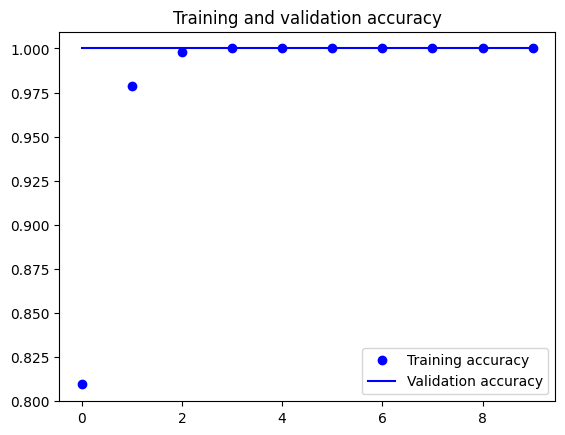

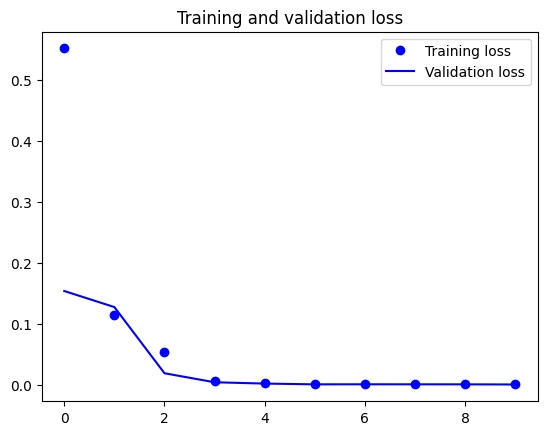

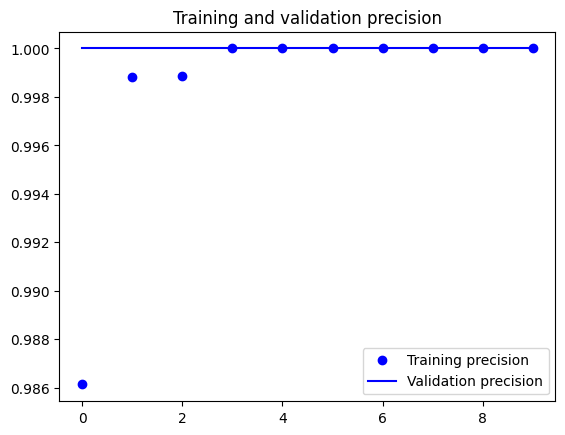

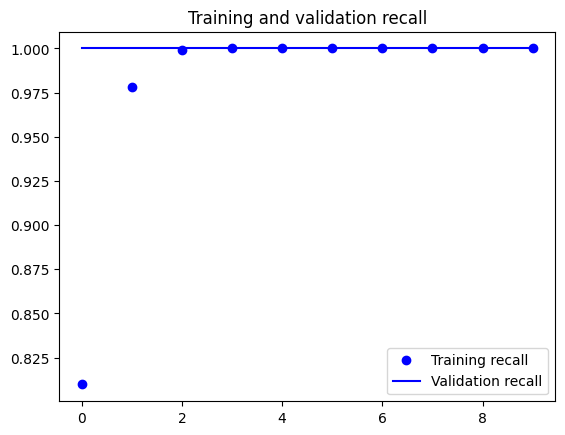

In [17]:
#Graph the accuracy and the loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
#Graph the accuracy and the loss
precision = history.history['precision_2']
val_precision = history.history['val_precision_2']
recall = history.history['recall_2']
val_recall = history.history['val_recall_2']
epochs = range(len(precision))
plt.plot(epochs, precision, 'bo', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()
plt.plot(epochs, recall, 'bo', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

Plot the Reciever Operating Characteristic (ROC) and AUC

In [21]:
y_probs = pipe_model.predict(test_X)
#convert into integer value
y_preds = test_Y.astype(int)

10/10 [==============================] - 2s 146ms/step


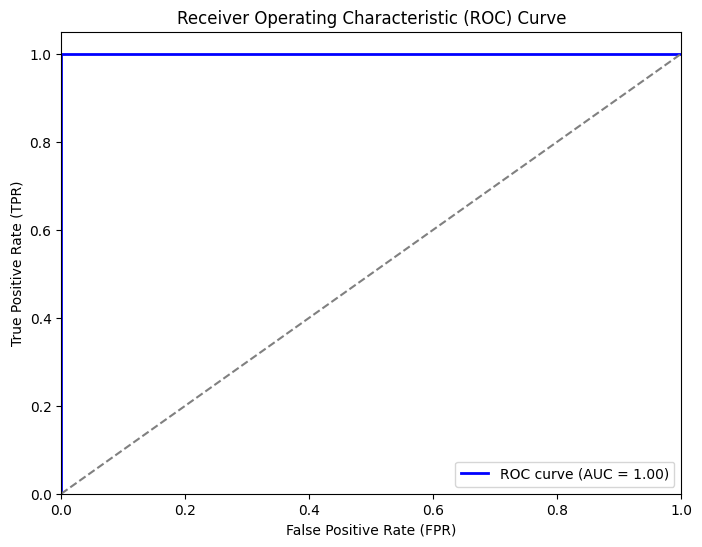

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_Y, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix

In [23]:
#for confusion matrix
from matplotlib import colormaps
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

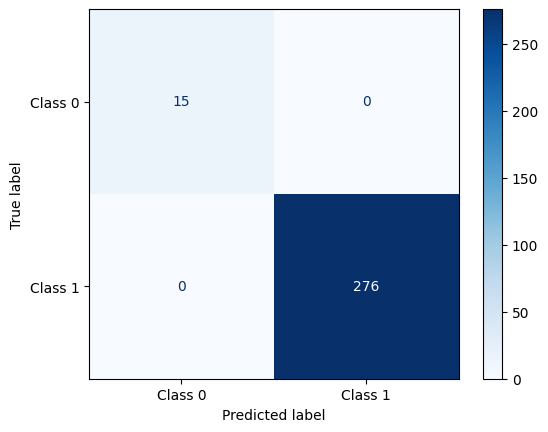

In [24]:
cm = confusion_matrix(test_Y, y_preds)

#plot it
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues, values_format='d');
plt.show()

Classification Report

In [25]:
from sklearn.metrics import classification_report
report = classification_report(test_Y, y_preds, target_names=['Class 0', 'Class 1'])
print(report)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        15
     Class 1       1.00      1.00      1.00       276

    accuracy                           1.00       291
   macro avg       1.00      1.00      1.00       291
weighted avg       1.00      1.00      1.00       291



In [97]:
prediction = pipe_model.predict(test_X)

10/10 [==============================] - 1s 120ms/step
